# Genetic optimization of XTree classifier for the SDSS data

## Load data

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [2]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {
    "n_estimators": np.logspace(2, 3.5, num=10, base=10, dtype=int),
    "criterion": ['gini', 'entropy'],
    "min_samples_split": range(2, 10),
    "min_samples_leaf": range(1, 10),
    "max_features": ['auto', 'log2', None],
    "bootstrap": [True, False],
    "oob_score": [False, True],
    "random_state": [42]
}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=ExtraTreesClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=3,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=15,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X_train, y_train)

Types [1, 1, 1, 1, 1, 1, 1, 1] and maxint [9, 1, 7, 8, 2, 1, 1, 0] detected
[CV] n_estimators=215, criterion=gini, min_samples_split=6, min_samples_leaf=2, max_features=log2, bootstrap=False, oob_score=True, random_state=42 
[CV] n_estimators=2154, criterion=entropy, min_samples_split=5, min_samples_leaf=5, max_features=log2, bootstrap=False, oob_score=True, random_state=42 
[CV] n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42 
[CV] n_estimators=464, criterion=gini, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=gini, min_samples_split=6, min_samples_leaf=2, max_features=log2, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=215, criterion=gini, min_samples_split=6, min_samples_leaf=2, max_features=log2, bootstrap=False, oob_score=True, random_state=4

[CV]  n_estimators=464, criterion=gini, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9646902065289806, total=   0.7s
[CV] n_estimators=464, criterion=gini, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=100, criterion=entropy, min_samples_split=2, min_samples_leaf=5, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=   0.4s
[CV] n_estimators=100, criterion=entropy, min_samples_split=2, min_samples_leaf=5, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=9, min_samples_leaf=1, max_features=log2, bootstrap=False, oob_score=False, random_state=42, score=0.9813457694870087, total=   0.8s
[CV] n_estimators=316, criterion=gini, min_samples_split=9, min_samples_leaf=1, max_features=log2, bootstrap=False, oob_sco

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=5, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9586942038640907, total=   0.3s
[CV] n_estimators=146, criterion=entropy, min_samples_split=5, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9853431045969354, total=   6.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.987341772

[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=3, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9773333333333334, total=   0.4s
[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=3, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=log2, bootstrap=False, oob_score=False, random_state=42, score=0.9820119920053297, total=   5.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=log2, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=3, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9726484322881921, total=   0.4s
[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=3, max_features=auto, bootstrap=True, o

[CV] n_estimators=100, criterion=entropy, min_samples_split=8, min_samples_leaf=5, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=100, criterion=entropy, min_samples_split=8, min_samples_leaf=5, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9613075383589059, total=   0.2s
[CV] n_estimators=100, criterion=entropy, min_samples_split=8, min_samples_leaf=5, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=100, criterion=entropy, min_samples_split=8, min_samples_leaf=5, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9673115410273516, total=   0.2s
[CV] n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=7, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.

[CV] n_estimators=681, criterion=entropy, min_samples_split=3, min_samples_leaf=8, max_features=log2, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=681, criterion=entropy, min_samples_split=7, min_samples_leaf=2, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9866666666666667, total=   2.5s
[CV] n_estimators=681, criterion=entropy, min_samples_split=7, min_samples_leaf=2, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=681, criterion=entropy, min_samples_split=3, min_samples_leaf=8, max_features=log2, bootstrap=True, oob_score=False, random_state=42, score=0.977348434377082, total=   1.8s
[CV] n_estimators=681, criterion=entropy, min_samples_split=3, min_samples_leaf=8, max_features=log2, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.989

[CV]  n_estimators=2154, criterion=gini, min_samples_split=6, min_samples_leaf=5, max_features=log2, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=146, criterion=entropy, min_samples_split=8, min_samples_leaf=9, max_features=log2, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=8, min_samples_leaf=9, max_features=log2, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=146, criterion=entropy, min_samples_split=8, min_samples_leaf=9, max_features=log2, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=8, min_samples_leaf=9, max_features=log2, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=146, criterion=entropy, min_samples_split=8, min_samples_leaf=9, max_features=log2, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_esti

[CV] n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=6, max_features=auto, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_est

[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=9, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9886591060707138, total=   0.5s
[CV] n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=9, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=3, min_samples_leaf=9, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9886591060707138, total=   0.5s
[CV] n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=

[CV]  n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=9, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9879919946631087, total=   0.7s
[CV]  n_estimators=3162, criterion=entropy, min_samples_split=9, min_samples_leaf=5, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9846768820786143, total=  12.7s
[CV] n_estimators=3162, criterion=entropy, min_samples_split=9, min_samples_leaf=5, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=1467, criterion=entropy, min_samples_split=7, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=True, random_state=42, score=0.9599733155436958, total=   3.8s
[CV] n_estimators=1467, criterion=entropy, min_samples_split=7, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=log2, bootstrap=True, oob_

[CV]  n_estimators=2154, criterion=entropy, min_samples_split=9, min_samples_leaf=9, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9753333333333334, total=   6.4s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=9, min_samples_leaf=9, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=3162, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=log2, bootstrap=True, oob_score=False, random_state=42, score=0.9846564376250834, total=   7.1s
[CV]  n_estimators=2154, criterion=entropy, min_samples_split=9, min_samples_leaf=9, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9739826551034023, total=   4.7s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=9, min_samples_leaf=9, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True,

[CV] n_estimators=146, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=215, criterion=gini, min_samples_split=8, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9893333333333333, total=   0.8s
[CV] n_estimators=215, criterion=gini, min_samples_split=8, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9699799866577719, total=   0.5s
[CV] n_estimators=215, criterion=entropy, min_samples_split=3, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=146, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=True, oob_score=True, random_state=42, score=0.9846564376

[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.99, total=   0.9s
[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9866755496335776, total=   4.2s
[CV] n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9840106595602931, total

[CV]  n_estimators=146, criterion=entropy, min_samples_split=5, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.972018654230513, total=   0.3s
[CV] n_estimators=146, criterion=entropy, min_samples_split=5, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.99, total=  11.3s
[CV] n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=entropy, min_samples_split=5, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, random_state=42, score=0.9586942038640907, total=   0.3s
[CV] n_estimators=146, criterion=entropy, min_samples_split=5, min_samples_leaf=7, max_features=auto, bootstrap=True, oob_score=False, ran

[CV] n_estimators=1467, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9893262174783188, total=   8.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9866577718478986, total=  11.2s
[CV] n_estimators=3162, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.985343104596935

[CV]  n_estimators=146, criterion=gini, min_samples_split=9, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.983344437041972, total=   0.5s
[CV] n_estimators=146, criterion=gini, min_samples_split=9, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=gini, min_samples_split=9, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9800133244503664, total=   0.5s
[CV] n_estimators=146, criterion=gini, min_samples_split=9, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   1.5s
[CV] n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, ran

[CV]  n_estimators=146, criterion=gini, min_samples_split=3, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9886666666666667, total=   0.5s
[CV] n_estimators=146, criterion=gini, min_samples_split=3, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=   1.5s
[CV]  n_estimators=1467, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9866577718478986, total=   5.0s
[CV] n_estimators=1467, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=146, criterion=gini, min_samples_split=3, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=True, r

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=3162, criterion=gini, min_samples_split=8, min_samples_leaf=7, max_features=log2, bootstrap=True, oob_score=True, random_state=42, score=0.9753333333333334, total=   8.9s
[CV] n_estimators=3162, criterion=gini, min_samples_split=8, min_samples_leaf=7, max_features=log2, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.4s
[CV]  n_estimators=3162, criterion=gini, min_samples_split=8, min_samples_leaf=7, max_features=log2, bootstrap=True, oob_score

[CV] n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9886591060707138, total=   0.8s
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913333333333333, total=   1.1s
[CV] n_estimators=215, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   1.6s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=

[CV]  n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.989993328885924, total=   1.6s
[CV] n_estimators=316, criterion=gini, min_samples_split=8, min_samples_leaf=6, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.989993328885924, total=   1.6s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9853431045969354, total=   4.0s
[CV] n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True

[CV] n_estimators=146, criterion=entropy, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9913333333333333, total=   0.9s
[CV] n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9853431045969354, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9833444370

[CV]  n_estimators=215, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9893262174783188, total=   0.8s
[CV] n_estimators=215, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.989993328885924, total=   0.8s
[CV] n_estimators=464, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.989993328885924, total=   4.1s
[CV] n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=

[CV] n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  10.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9886591060707138, total=   8.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=3162, criterion=entropy, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=True, oob_score=False, random_state=42, score=0.98665

[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=log2, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
2  	28    	0.888813	0  	0.989467	0.29628 
[CV]  n_estimators=100, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   0.5s
[CV] n_estimators=100, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.985

[CV] n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.989993328885924, total=   0.8s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.9799866577718479, total=   1.0s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9

[CV] n_estimators=2154, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV]

[CV]  n_estimators=100, criterion=entropy, min_samples_split=3, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9906604402935291, total=   0.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9906604402935291, total=   1.2s
[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913333333333333, total=   1.1s
[CV] n_estimators=215, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=None, bootstrap=Fal

[CV]  n_estimators=316, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=215, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=   1.7s
[CV] n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9846768820786143, total=   1.0s
[CV] n_estimators=215, criterion=gini, min_samples_split=2, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, rand

[CV]  n_estimators=2154, criterion=gini, min_samples_split=6, min_samples_leaf=3, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.989993328885924, total=   7.5s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  10.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.992, total=   7.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=None, bootstrap=False, oob_score=False, ra

[CV]  n_estimators=316, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=log2, bootstrap=False, oob_score=False, random_state=42, score=0.988, total=   1.2s
[CV] n_estimators=316, criterion=entropy, min_samples_split=6, min_samples_leaf=2, max_features=log2, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9880079946702198, total=   4.2s
[CV] n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9880079946702198, total=   4.2s
[CV] n_estimators=1000, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, rando

[CV] n_estimators=316, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.978014656895403, total=   7.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   1.6s
[CV] n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9860093271

[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.989993328885924, total=   1.6s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   1.6s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   1.6s
[CV] n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=Fa

[CV]  n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9853431045969354, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9886591060707138, total=   6.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.9866577718478986, total=   6.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score

[CV] n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   1.6s
[CV] n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9913333333333333, total=   2.7s
[CV] n_estimators=1000, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=entropy, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score

[CV]  n_estimators=1000, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9846768820786143, total=   2.9s
[CV] n_estimators=1000, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   9.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=1000, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=True, random_state=42, score=0.9913333333333333, total=   3.0s
[CV] n_estimators=1000, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=True, oob_score=Tr

[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
4  	31    	0.969048	0  	0.989467	0.13844 
[CV]  n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   1.1s
[CV] n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.988007

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=entropy, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   7.6s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False,

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.9s
[CV] n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   8.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sc

[CV]  n_estimators=316, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   1.5s
[CV] n_estimators=316, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.989993328885924, total=   1.6s
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   1.1s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=Fa

[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=681, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   3.3s
[CV] n_estimators=681, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   1.1s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.98800799

[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
5  	29    	0.969525	0  	0.989467	0.138504
[CV]  n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   1.1s
[CV] n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   1.1s
[CV] n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9879919946631087, total=   5.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sco

[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913333333333333, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   8.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   8.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   1.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=2, min_samples_leaf=2, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.6s
[CV] n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sco

[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=   1.1s
[CV] n_estimators=316, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sco

[CV]  n_estimators=316, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   1.1s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sc

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  10.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9879919946631087, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sco

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.991

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.992

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   9.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   8.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.8s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=True, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=True, random_state=42, score=0.0, total=   0.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=True, random

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.986

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.991

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.992

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   8.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   8.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  10.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.978014656895403, total=   7.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sc

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=4, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.986

[CV] n_estimators=2154, criterion=gini, min_samples_split=3, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860

[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.9853333333333333, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_score=False, random_state=42, score=0.9913333333333333, total=   8.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=True, oob_sco

[CV] n_estimators=100, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=100, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   0.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=681, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   3.4s
[CV] n_estimators=681, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=681, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.98600932

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=3, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.989

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   8.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.986

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=8, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9820119920053297, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=8, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   8.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.989

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   7.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   7.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.986

[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.6s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=5, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9860093271152565, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=5, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.5s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.4s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=7, min_samples_leaf=

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=  11.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=  12.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.9853333333333333, total=   7.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.0s
[CV] n_estimators=2154, criterion=entropy, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oo

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.3s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=log2, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
11 	30    	0.989339	0.983333	0.989467	0.000858716
[CV]  n_estimators=2154, criterion=gini, min

[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.992

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.988

[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.988

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   9.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  10.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.1s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  11.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  10.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.3s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=6, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   1.2s
[CV] n_estimators=215, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_sco

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=6, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=6, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  10.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   7.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=8, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   7.5s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   9.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9893262174783188, total=   9.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=4, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9866755496335776, total=   7.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   8.9s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  10.0s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=   7.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=   7.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV] n_estim

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.6s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=   7.7s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  10.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9926666666666667, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9880079946702198, total=  11.2s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_score=False, random_state=42, score=0.9853333333333333, total=   7.8s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=False, oob_s

[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9913275517011341, total=  11.2s
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.4s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42, score=0.9886591060707138, total=  11.3s
[CV] n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=None, bootstrap=False, oob_score=False, random_state=42 
[CV]  n_estimators=2154, criterion=gini, min_samples_split=7, min_samples_leaf=1, max_features=auto, bootstrap=True, oob_s

Data Set Type:  Standard Scaled
ExtraTreesClassifier
[0.98800799 0.98467688 0.994      0.98799199 0.99132755]
Accuracy: 0.989 (+/- 0.006)
ExtraTreesClassifier :
 [[1234    5    7]
 [  14  228    0]
 [   1    0 1011]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
ExtraTreesClassifier 0.9892008846226155


By Precision(avg=micro):
ExtraTreesClassifier 0.9892


By Recall(avg=micro):
ExtraTreesClassifier 0.9892


By F1(avg=micro):
ExtraTreesClassifier 0.9892


By Precision(avg=macro):
ExtraTreesClassifier 0.9865516456494005


By Recall(avg=macro):
ExtraTreesClassifier 0.9771765998061684


By F1(avg=macro):
ExtraTreesClassifier 0.9817458233379731


Extr

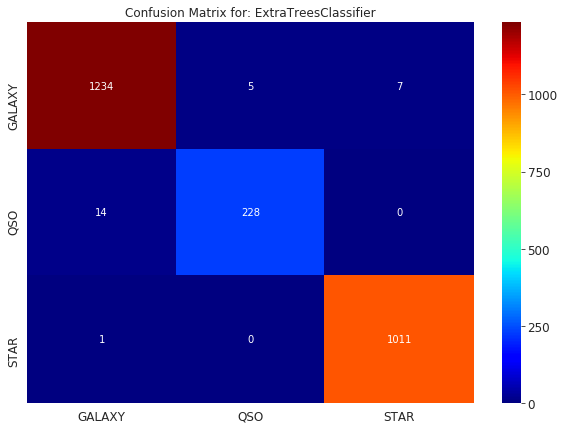

In [2]:
best_indiv = ExtraTreesClassifier(n_estimators=2154,
                                  criterion="gini",
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  bootstrap=False,
                                  oob_score=False,
                                  random_state=42)

clf_names = ["ExtraTreesClassifier"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs = [best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)